In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, log_loss, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix
import xgboost as xgb
import numpy as np
import pickle, itertools
from sklearn.model_selection import train_test_split
import shap

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load the train dataset from the CSV file
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_feats.csv')
# Replace infinite values with NaN
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [3]:
# Extract the target variable from the dataset
y_train = train_set['Target > 2']
# Drop unnecessary columns and keep the feature matrix
x_train = train_set.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [4]:
# Load the best X features from the metadata file
with open("./metadata/clf_top_K_feats.pkl", "rb") as f:
    top_k_feats = pickle.load(f)

# Keep only the best X features
x_train = x_train[list(top_k_feats)]

In [5]:
# Split the data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Drop the first 5 rows of the validation set to avoid leakage from lagged features
X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [6]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'eval_metric': ['logloss'],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, np.sqrt(sum(y_train==0)/sum(y_train==1))]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [7]:
# Initialize empty lists to store results
auc_scores = []
aucpr_scores = []
best_thresholds = []
confusion_matrices = []
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    clf = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=15)

    # Make predictions on the test set
    y_pred_train = clf.predict(dtrain)
    y_pred_val = clf.predict(dval)

    num_trees = clf.best_ntree_limit
    num_trees_list.append(num_trees)

    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val)
    
    # Calculate AUC and AUCPR
    print(f'AUC={auc(recall, precision)}')
    print(f'AUCPR={average_precision_score(y_val, y_pred_val)}')
    auc_scores.append(auc(recall, precision))
    aucpr_scores.append(average_precision_score(y_val, y_pred_val))

    # Find the best threshold
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_threshold)

    # Calculate TP, FP, FN using the best threshold
    y_pred = (y_pred_val > best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    confusion_matrices.append((tp, fp, fn))
    print(f'TP={tp}, FP={fp}, FN={fn}')

    print('--'*5)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'AUC': auc_scores[i],
        'AUCPR': aucpr_scores[i],
        'Best_threshold': best_thresholds[i],
        'TP': confusion_matrices[i][0],
        'FP': confusion_matrices[i][1],
        'FN': confusion_matrices[i][2],
    })

AUC=0.957957338185554
AUCPR=0.9582607172586345
TP=167, FP=9, FN=21
----------
AUC=0.962671590216845
AUCPR=0.9629504887352252
TP=172, FP=13, FN=16
----------
AUC=0.9579844271233321
AUCPR=0.9583118631582614
TP=172, FP=12, FN=16
----------
AUC=0.9587220021205837
AUCPR=0.9590363158542816
TP=173, FP=11, FN=15
----------
AUC=0.9642654931593299
AUCPR=0.9644587522450706
TP=168, FP=10, FN=20
----------
AUC=0.9654436594838363
AUCPR=0.9656198950362282
TP=171, FP=10, FN=17
----------
AUC=0.9625808774976403
AUCPR=0.9627693079020332
TP=171, FP=15, FN=17
----------
AUC=0.9597230406777569
AUCPR=0.9599952204121914
TP=173, FP=10, FN=15
----------
AUC=0.9633223776379174
AUCPR=0.9635129130500657
TP=177, FP=20, FN=11
----------
AUC=0.9653978127722944
AUCPR=0.9655610619962018
TP=173, FP=12, FN=15
----------
AUC=0.9579065415950467
AUCPR=0.9582597276195413
TP=178, FP=21, FN=10
----------
AUC=0.9630219025686014
AUCPR=0.9632327835200373
TP=173, FP=13, FN=15
----------
AUC=0.9643751791140577
AUCPR=0.964534740762

## Get best result

In [8]:
# Find the best hyperparameters based on the highest AUCPR
best_idx = np.argmax([x['AUCPR'] for x in results])

# Get the best threshold, hyperparameters, and optimal number of trees
best_threshold = results[best_idx]['Best_threshold']
best_hyperparams = results[best_idx]['hyperparameters']
opt_num_trees = num_trees_list[best_idx]

print(results[best_idx])
print(f'Num of trees: {opt_num_trees}')

{'hyperparameters': {'alpha': 1, 'lambda': 5, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 0.7, 'eval_metric': 'logloss', 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1}, 'AUC': 0.9672383216320641, 'AUCPR': 0.9673595167948149, 'Best_threshold': 0.30402938, 'TP': 174, 'FP': 18, 'FN': 14}
Num of trees: 451


In [31]:
# Retrain with best parameters
clf = xgb.train(best_hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=opt_num_trees)

[0]	train-logloss:0.64744	test-logloss:0.64665
[1]	train-logloss:0.60615	test-logloss:0.60468
[2]	train-logloss:0.56856	test-logloss:0.56638
[3]	train-logloss:0.53422	test-logloss:0.53128
[4]	train-logloss:0.50277	test-logloss:0.49913
[5]	train-logloss:0.47390	test-logloss:0.46957
[6]	train-logloss:0.44727	test-logloss:0.44227
[7]	train-logloss:0.42266	test-logloss:0.41687
[8]	train-logloss:0.39986	test-logloss:0.39340
[9]	train-logloss:0.37873	test-logloss:0.37178
[10]	train-logloss:0.35907	test-logloss:0.35163
[11]	train-logloss:0.34078	test-logloss:0.33286
[12]	train-logloss:0.32375	test-logloss:0.31525
[13]	train-logloss:0.30783	test-logloss:0.29890
[14]	train-logloss:0.29291	test-logloss:0.28352
[15]	train-logloss:0.27901	test-logloss:0.26912
[16]	train-logloss:0.26597	test-logloss:0.25562
[17]	train-logloss:0.25376	test-logloss:0.24302
[18]	train-logloss:0.24235	test-logloss:0.23119
[19]	train-logloss:0.23164	test-logloss:0.22007
[20]	train-logloss:0.22157	test-logloss:0.20968
[2

In [32]:
# Make predictions on training and validation data
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

In [33]:
# Save predictions for the regressor
preds = (y_pred_train >= best_threshold).astype(int)
with open('./output/classifier/y_train2_clf_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

# Save predictions for the regressor
preds = (y_pred_val >= best_threshold).astype(int)
with open('./output/classifier/y_val2_clf_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

In [34]:
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 15})

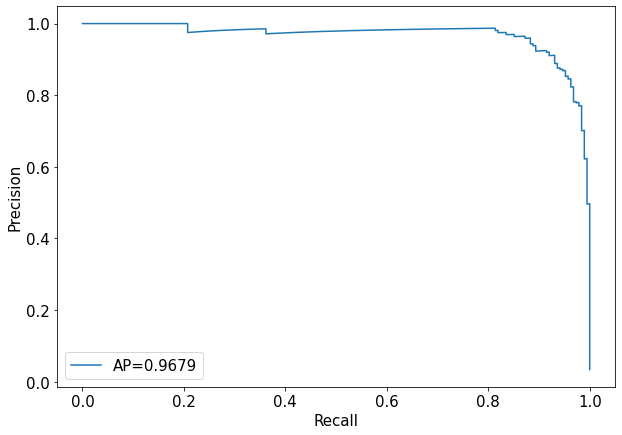

In [35]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
average_precision = average_precision_score(y_val, y_pred_val)
plt.plot(recall, precision, label='AP={:.4f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [44]:
# predict binary labels using the best threshold
y_pred = (y_pred_val >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[5282,   17],
       [  13,  175]], dtype=int64)

# Predict on test set

In [14]:
# best_hyperparams = {'alpha': 1, 'lambda': 1, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.7, 'eval_metric': 'logloss', 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 4.8074904964820355}
# opt_num_trees = 526

In [46]:
# Extract the target variable from the dataset
y_train = train_set['Target > 2']
# Drop unnecessary columns and keep the feature matrix
x_train = train_set.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)

# Keep only the best X features
x_train = x_train[list(top_k_feats)]
dfull = xgb.DMatrix(x_train, y_train)

In [47]:
# Retrain the model with the best hyperparameters using all available data
clf = xgb.train(best_hyperparams,dfull,num_boost_round=int(opt_num_trees*1.09))
y_pred_train = clf.predict(dfull)

In [48]:
# Load test set
df_test = pd.read_csv('./data/test_df_expanded_feats.csv')
# Keep only the best X features for the test set
df_test = df_test[list(top_k_feats)]
# Replace infinite values with NaN
df_test = df_test.replace([np.inf, -np.inf], np.nan)
# Convert the test set into an XGBoost DMatrix object
df_test = xgb.DMatrix(df_test)

# Make predictions on the test dataset using the trained model
y_pred_test = clf.predict(df_test)

In [49]:
# Save predictions for the regressor
preds = (y_pred_train >= best_threshold).astype(int)
with open('./output/y_train3_clf_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

# Save predictions for the regressor
preds = (y_pred_test >= best_threshold).astype(int)
with open('./output/y_test_clf_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

# Save trained model into a pickle file
clf.save_model('./output/xgb_final_classifier.json')

### Plotting results

In [41]:
# Rearrange features to group them in image
cols = ['Avg_CCS1_WHCO2InjPs_psi',
 'Avg_CCS1_WHCO2InjPs_psi ema 5',
 'Avg_CCS1_WHCO2InjPs_psi_diff1',
 'Avg_CCS1_WHCO2InjPs_psi_diff2',
 'Avg_CCS1_WHCO2InjPs_psi_diff3',
 'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
 'Avg_CCS1_WHCO2InjPs_psi_pct_change5',
 'Avg_CCS1_WHCO2InjTp_F_diff1',
 'Avg_PLT_CO2VentRate_TPH_diff1',
 'Avg_PLT_CO2VentRate_TPH_pct_change1',
 'Avg_PLT_CO2VentRate_TPH_pct_change5',
 'Avg_CCS1_DH6325Ps_psi',
 'Avg_CCS1_DH6325Ps_psi_diff1',
 'Avg_CCS1_DH6325Ps_psi_pct_change1',
 'Pressure diff 5482-5001 ft ema 5',
 'Pressure diff 6837-6720 ft_lag5',
 'Temperature diff 5840-5482 ft_lag3',
 'Temperature diff 6720-5653 ft sma 5'
]

full_x = full_x[cols]
dfull = xgb.DMatrix(full_x, full_y)

In [42]:
# Calculate shap values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(full_x)

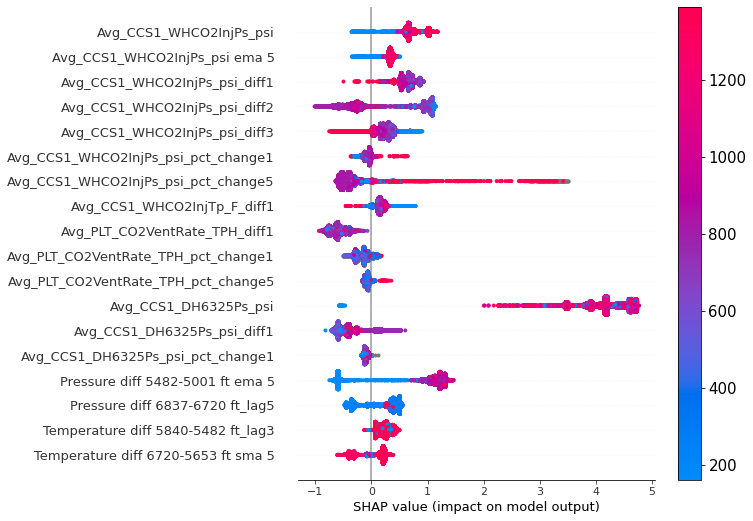

In [43]:
order = full_x.columns
col2num = {col: i for i, col in enumerate(full_x.columns)}
order = list(map(col2num.get, order))

shap.plots.beeswarm(shap_values, max_display=18, show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()